<a href="https://colab.research.google.com/github/mdanyalmalik/chest-xray-synthesis/blob/main/Data_Synthesis_For_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CS 437 Final Project
## Evaluating the feasibility of using Generative Models to generate Chest XRay Data
### M. Danyal Malik, Danish Humair


In [1]:
#@title Check Runtime GPU

!nvidia-smi # Make sure you are using a GPU runtime

Thu Apr 27 10:59:00 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    42W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
#@title Imports

!pip install diffusers==0.11.1 transformers scipy ftfy accelerate

import os
import torch, gc
import IPython
from google.colab import drive
from diffusers import StableDiffusionPipeline
from PIL import Image

IPython.display.clear_output()
print("Installed all dependencies")

drive.mount('/content/drive')

Installed all dependencies
Mounted at /content/drive


In [24]:
#@title Upload Model

path_type = "Google Drive" #@param ["Google Drive", "Hugging Face", "Local Path"]
path = "CXR/CXR-F-3000.ckpt" #@param {type:"string"}
clean = False #@param {type:"boolean"}
model_name = path.split("/")[-1].replace(".ckpt", "")

if path_type != "Hugging Face":
    if clean and os.path.exists(f"/content/{model_name}"):
        !rm -rf {"/content/"+model_name}
        print("Deleted old model")
    
    if not os.path.exists(f"/content/{model_name}"):
        if path_type == "Google Drive":
            path = "/content/drive/MyDrive/" + path
        
        !wget -q -O convertodiff.py https://raw.githubusercontent.com/TheLastBen/fast-stable-diffusion/main/Dreambooth/convertodiffv2.py
        !python /content/convertodiff.py {path} {"/content/"+model_name} --v2 --reference_model stabilityai/stable-diffusion-2-1-base
        !rm /content/convertodiff.py
        
        path = "/content/"+model_name
        print("Uploaded model to", path)
    else:
        path = "/content/"+model_name
        print("Model is already uploaded")

2023-04-27 12:03:03.082760: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Converting to Diffusers ...
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
Uploaded model to /content/CXR-F-3000


In [25]:
#@title Load Model

pipe = StableDiffusionPipeline.from_pretrained(path, torch_dtype=torch.float16)
pipe = pipe.to("cuda")

print("Loaded model to pipeline")

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Loaded model to pipeline


In [26]:
#@title Batch Generate Images

prompt = "ChestXRay Edema" #@param ["ChestXRay No Finding", "ChestXRay Hernia", "ChestXRay Emphysema", "ChestXRay Nodule", "ChestXRay Pneumonia", "ChestXRay Consolidation", "ChestXRay Cardiomegaly", "ChestXRay Effusion", "ChestXRay Mass", "ChestXRay Pleural_Thickening", "ChestXRay Atelectasis", "ChestXRay Pneumothorax", "ChestXRay Fibrosis", "ChestXRay Infiltration", "ChestXRay Edema"] {allow-input: true}
iterations = 39 #@param {type:"integer"}
amount = 16 #@param {type:"integer"}
steps = 60 #@param {type:"slider", min:10, max:120}
out_gdrive = False #@param {type:"boolean"}
out_path = "output" #@param {type:"string"}
keep_for_CheXNet_evaluation = False #@param {type:"boolean"}
repeat_for_all_prompts = False #@param {type:"boolean"}
clean = False #@param {type:"boolean"}

if clean:
    !rm -rf eval
    !rm -rf output

diseases = [
    'Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia',
    'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia'
]

prompts = []
if repeat_for_all_prompts:
    prompts.append(f"ChestXRay No Finding")
    for d in diseases:
        prompts.append(f"ChestXRay {d}")
else:
    prompts = [prompt]

for prompt in prompts:
    names_for_evaluation = []
    label = ["0" for i in range(14)]
    disease = 0

    for x in range(len(diseases)):
        if diseases[x] in prompt:
            label[x] = "1"
            disease = x + 1

    if keep_for_CheXNet_evaluation:
        if not os.path.exists("eval"):
            os.makedirs("eval")
            os.makedirs("eval/images")
            os.makedirs("eval/labels")

    if out_gdrive:
        out_path = "/content/drive/MyDrive/" + out_path
        if out_path[-1] == "/":
            out_path = out_path[:-1]

    if not os.path.exists(out_path):
        os.makedirs(out_path)

    for x in range(iterations):
        print("Generating", amount, "images...")
        print("Seeds:", end=" ")

        generator = []
        for i in range(amount):
            seed = torch.Generator(device="cuda")
            print(seed.seed(), end=" ")
            generator.append(seed)
        print()

        images = pipe(prompt, num_inference_steps=steps, generator=generator, num_images_per_prompt=amount).images
        for i in range(len(images)):
            images[i].save(f"{out_path}/{model_name}_{prompt}_{generator[i].seed()}.png")
            if keep_for_CheXNet_evaluation:
              filename = f"{str(disease).zfill(2)}_{str(x).zfill(8)}_{str(i).zfill(3)}.png"
              images[i].save(f"eval/images/{filename}")
              names_for_evaluation.append(filename)
        
        print("Saved", amount, "images")

        del images

    if keep_for_CheXNet_evaluation:
        f = open("eval/labels/test_list.txt", "a")
        for name in names_for_evaluation:
            f.write(f"{name} {' '.join(label)}\n")
        f.close()

Generating 16 images...
Seeds: 8862491197341514 2518009630868855 3120905984946487 602692621491855 1324832566548277 1749451329257558 5824604316661194 6664623499321179 8521395191782364 4553074812860518 4945267998106311 4458854016633106 1760559109653620 8102523352841352 3837142977095801 74291267294107 


  0%|          | 0/60 [00:00<?, ?it/s]

Saved 16 images
Generating 16 images...
Seeds: 8660438958584271 8553767388716502 8955197768013770 5744744603452596 1391399888419422 1316772649201288 1398954662190793 4867051043898335 7198260644959249 3469282874115330 8358810852138284 5267220826661236 5489485156450049 2288487821675438 1144406036327651 6022543810599257 


  0%|          | 0/60 [00:00<?, ?it/s]

Saved 16 images
Generating 16 images...
Seeds: 9940061383376 8548217097490028 286720762749621 1825638822881228 6359399808631717 3124264839946656 5948206730580145 8468957880118326 4460989885407539 2326210960174377 90702290820785 943902614362557 4539949783004314 4558255127757151 8898907239038514 3730941704526097 


  0%|          | 0/60 [00:00<?, ?it/s]

Saved 16 images
Generating 16 images...
Seeds: 8580856901316730 5405047315860679 2102767776607172 2183601762208144 6045046857738199 1314377663683700 4818738206364817 5610699297371438 3009879143876826 8251913626107802 2443132933016360 5986659590141567 1803986254949952 3753251159032711 5133560466038629 836998003524181 


  0%|          | 0/60 [00:00<?, ?it/s]

Saved 16 images
Generating 16 images...
Seeds: 7447573369828402 5545577683823714 7465924389608063 6117755424301476 1818454583394663 5588921034224977 3799772943239961 5588139447613185 7138523560311671 4586050882962044 6673626800665915 6926314136615240 8026734119868448 3411334655127989 8175390128534168 7855012026158719 


  0%|          | 0/60 [00:00<?, ?it/s]

Saved 16 images
Generating 16 images...
Seeds: 3347863991648728 8694795530994760 5594458200391979 8255442947885841 4332489075488946 219661493212415 6896391073263027 1135183984236829 3912586918044914 7587082527491098 2002135063913467 4880429179612209 1158763578940345 3145682770551712 8019304811689694 6689050780835666 


  0%|          | 0/60 [00:00<?, ?it/s]

Saved 16 images
Generating 16 images...
Seeds: 2978581380144323 3885525403176098 1375243528084443 8271538441600243 656975924444973 7612389256165644 144589519687620 1742425527858259 3183592621938784 6087414006490207 3303950639245258 6931450194829155 7785199950653757 3342920325616429 6085847846167893 7495192186742612 


  0%|          | 0/60 [00:00<?, ?it/s]

Saved 16 images
Generating 16 images...
Seeds: 6570248349809469 5792152937929282 4132551250997574 7323972731485056 3779681237820987 5189882883313725 6232457516134151 6809010421102463 3938291819555804 6164208712184338 423656396473678 7994409548916980 114722954733711 1294958232604122 6861872466006451 7417572883730712 


  0%|          | 0/60 [00:00<?, ?it/s]

Saved 16 images
Generating 16 images...
Seeds: 7418386810123943 4799908481030055 5928398495770109 7830748286580074 8320458150958685 8482569405756145 3135483000027052 8617782589126313 6973349568922735 4726688817476077 7570989913561593 3692443302393901 4863842952013120 5713963899537746 884187767029322 2922797826837197 


  0%|          | 0/60 [00:00<?, ?it/s]

Saved 16 images
Generating 16 images...
Seeds: 1782107294853907 8574239114716722 8721259652971477 2066134684006976 3079794029652106 1673664850677464 4236970030227333 4038417087759903 611946917528899 6988049003617184 1274504645475530 3694297693387460 6825795033027519 2926963209408431 4452224095832594 1767715030931994 


  0%|          | 0/60 [00:00<?, ?it/s]

Saved 16 images
Generating 16 images...
Seeds: 8913895996423750 3161482754474562 8387173252313863 4242086465333502 2218203333833878 7076962182444446 8787514898520514 3393110078697389 3561496625348672 3833540422494246 6690886569282964 1917060221035322 3290006404949817 438991487652150 1894837167075082 7856180320046626 


  0%|          | 0/60 [00:00<?, ?it/s]

Saved 16 images
Generating 16 images...
Seeds: 3350810391929584 6613626687563828 1566835037149932 654974596631814 5385170723424137 6112397720342268 2809907652586202 5910270112899550 8919363601212215 5696674241500170 4601743634507373 8324398590087730 532722515777366 164711352773265 3741837176617574 4868185177329351 


  0%|          | 0/60 [00:00<?, ?it/s]

Saved 16 images
Generating 16 images...
Seeds: 6067753672247854 1044243063980352 2037584914639396 5455637319969132 1277194434451597 8101179643968435 8184667910800668 8206862164421042 7307706549980982 5899888984161223 566365783489144 8945418526300033 2891086449264978 1914721210479955 1380326067072833 646469318739312 


  0%|          | 0/60 [00:00<?, ?it/s]

Saved 16 images
Generating 16 images...
Seeds: 2442620438922340 5967033069409558 8872325969785753 3353831225712147 7132667950981658 4833640873796260 5739764215444065 8494167970654728 6309696202282793 3766468955084377 3714340801979212 8003877319825891 3297676570005998 2507128742625464 7302069982872557 4732532193633331 


  0%|          | 0/60 [00:00<?, ?it/s]

Saved 16 images
Generating 16 images...
Seeds: 6486940490240575 4036987692735843 133812926866670 5838454860425872 762666822757207 2520788146677901 2873786747977466 194445973389724 6623185452644333 1780569940093632 6855942596367759 3542473846186843 3009338763486120 2211519095214377 5211177931920874 2477978946712015 


  0%|          | 0/60 [00:00<?, ?it/s]

Saved 16 images
Generating 16 images...
Seeds: 3750488802513311 5127331174957644 2518774734536862 6667545148090473 2398593340743659 3654221499959295 2834983363424144 1429014097075222 4391687062889923 88639817931223 3356880755989202 3217120458582594 5568694297297098 750840535909497 481839313175786 6028001968711405 


  0%|          | 0/60 [00:00<?, ?it/s]

Saved 16 images
Generating 16 images...
Seeds: 7859426901005759 3686713797279129 6348725800284441 6385904847578406 6113689100950145 4309032402180046 3258497823464615 2015391312409056 2570592073512770 4181876391486635 7923219572246081 5177183171609187 3567566605224845 1239479444961510 2042322480324208 1175578235600688 


  0%|          | 0/60 [00:00<?, ?it/s]

Saved 16 images
Generating 16 images...
Seeds: 291015549887823 6040236503588214 3718805720503566 8049184716669550 8116115203361036 7744364396359866 5572536291295550 6147087577527574 3066635177121011 6881851764540083 1765083088592289 3239581700216959 7869074781453002 4177358781294107 191480305276936 2524532508841758 


  0%|          | 0/60 [00:00<?, ?it/s]

Saved 16 images
Generating 16 images...
Seeds: 4251845392757658 3124872753718325 7018495562155976 3869156757549208 5972768386886208 2820439652042272 7919726554841596 1027907630722177 7136353822110210 2749449778793083 2562557431303589 6097052929512768 5842887263289458 7355231061585865 6564721382660564 1340158649296639 


  0%|          | 0/60 [00:00<?, ?it/s]

Saved 16 images
Generating 16 images...
Seeds: 5810510970294280 3729176227165988 4202440551431137 6083414285059736 5071450790432200 7139608449168332 7699750648700944 4294726108648155 7147834076122833 7467160877731818 783074994871522 1015170753661034 8991239107890214 5586282691418019 4368690692680171 8923869279224272 


  0%|          | 0/60 [00:00<?, ?it/s]

Saved 16 images
Generating 16 images...
Seeds: 1892695357489172 2455418397221857 5373777221227447 892413895090932 112472956556498 5851266561818878 2683855089594000 6044171709177825 5756191340325369 549820572797708 199786348978235 5530277785240340 2407646864757888 3813537251393346 9005699061656269 2619535890764664 


  0%|          | 0/60 [00:00<?, ?it/s]

Saved 16 images
Generating 16 images...
Seeds: 7083415522259935 401912848885772 7207765781176826 2325869314600510 6352925114302014 5216951470630710 302541545797894 2136336020627358 3487241803649354 4343383547702601 8477793424808510 844549990392329 855626751048017 2104207025211199 4268988476776252 4220726204322797 


  0%|          | 0/60 [00:00<?, ?it/s]

Saved 16 images
Generating 16 images...
Seeds: 3625852281470799 8227027307413539 8653520636572981 5749692256595262 7010989362341006 8429365087400624 4011659535431936 8275198775818866 4805601501389823 8435654283975158 1010987576668554 7505639907925059 1317360467684308 6350045098678813 2761113085846479 5735058254282637 


  0%|          | 0/60 [00:00<?, ?it/s]

Saved 16 images
Generating 16 images...
Seeds: 8988356483222760 272939388548421 5185272637156973 2358529589653425 7950248656636767 8019315062218859 6803797892215710 1607856413178001 5098308039911411 2782241727764393 317515522667900 802774001437898 7617552699887445 4606050653024972 8850241371903239 3723266726196390 


  0%|          | 0/60 [00:00<?, ?it/s]

Saved 16 images
Generating 16 images...
Seeds: 4083963134897247 3355799876226952 4096971513399664 1971380498342886 5645203794126218 946451460494086 4120994537467320 1625234808143144 7045293867642535 3295576674664284 5299728599288349 3693822987752790 1358367767935515 7019698867875686 8066366248520061 55516385034382 


  0%|          | 0/60 [00:00<?, ?it/s]

Saved 16 images
Generating 16 images...
Seeds: 605787474950730 4868616045516568 8741549910665141 7157017906321322 7247472707147540 4943744573168338 4550109352607691 4716780888715679 102675197537466 6850840521505539 8853155781677536 8767139138054117 2937938992552944 4583000688685085 878484824050890 8417613526307699 


  0%|          | 0/60 [00:00<?, ?it/s]

Saved 16 images
Generating 16 images...
Seeds: 7697787075985374 2341609287834970 6059981886750881 5192501098987060 1608128511783122 920904916501128 2872669530420658 3314665050393409 2492464418980866 8578186691071879 7968863493105157 3018725204521945 6490567440210478 8291862718945558 2435218737589458 5214315715262716 


  0%|          | 0/60 [00:00<?, ?it/s]

Saved 16 images
Generating 16 images...
Seeds: 6207711029935544 620256310191390 5393896432356308 956336313713452 118800192425771 2753161803157299 5873159632543670 2414578826909688 5388787145506013 5692228291124242 664836793621469 1148025705165079 2727894832633338 8771587554167776 1026898204186121 772566212744131 


  0%|          | 0/60 [00:00<?, ?it/s]

Saved 16 images
Generating 16 images...
Seeds: 8670839537481981 1520493322745532 6994317267107943 4950390205606858 337994547893363 1582146588098620 4909906424723274 2301553262585546 7243150754182304 1643648331745664 5021135633048681 1640906838290035 5623763682316699 7426000036273870 7208876080583222 7212872951529838 


  0%|          | 0/60 [00:00<?, ?it/s]

Saved 16 images
Generating 16 images...
Seeds: 2814086054289904 1666017677238453 7887287059153730 6561637039067328 2512473249382517 2638722102614897 6759212991318459 7574094320967679 951313364138293 4756803972249546 8371512082687888 5517952239621449 2450761607411882 6030291259036128 885712396882038 1482761905788955 


  0%|          | 0/60 [00:00<?, ?it/s]

Saved 16 images
Generating 16 images...
Seeds: 7095198898691145 3784082570996629 228392240006295 1426570281399956 943183255411373 8253327666539192 5625555101780948 8789969629986747 6861812425031347 3789062680825273 7430510931190029 8002639896512043 7059799839845627 6969407670728622 1990487130796559 2561719761458103 


  0%|          | 0/60 [00:00<?, ?it/s]

Saved 16 images
Generating 16 images...
Seeds: 4421502443659291 3179831712484815 4613114428487056 7384208601748988 1245376796539441 7896236953684231 2562107406519199 515640118674577 6309929973545313 4006055739816284 3997663154048006 8584254725481382 4312803850109332 3347916207237711 2755968449095865 5043449014051852 


  0%|          | 0/60 [00:00<?, ?it/s]

Saved 16 images
Generating 16 images...
Seeds: 4282163411539874 5380726700575316 7011911274171158 5621090606817008 6418680340015450 5553231505511733 2399062993807932 7813785989738052 4384567034989297 5519534712185445 5624647654166923 5762807077919871 7759615723422519 4678708324365836 329802784192689 5389471281356537 


  0%|          | 0/60 [00:00<?, ?it/s]

Saved 16 images
Generating 16 images...
Seeds: 827452218190457 6965429916829454 3324832997165218 7140326361340878 4597347521965254 2244024372074080 5423654875143743 6434024524574887 7080240851457957 8879136311028220 6189025865349269 6903231020201821 5293018404210318 223371257891440 3090184421396174 7847318874800788 


  0%|          | 0/60 [00:00<?, ?it/s]

Saved 16 images
Generating 16 images...
Seeds: 5075501589357076 6279173729190452 7486068401372780 5038555710850088 103480494258688 1872791900512275 6511318394266690 1513954802475075 1835304705541796 3548601942811946 2310989132692477 3268512379382658 875092226754601 4728896255012262 2431730783068164 7100140710451834 


  0%|          | 0/60 [00:00<?, ?it/s]

Saved 16 images
Generating 16 images...
Seeds: 7456806357718287 2815951386390551 4937764750489563 8626521161507839 7813985068682668 7250257683500801 1760189341608309 847428204543420 6178358204792656 7824738125879537 1177157699043453 7439085003754925 310099326478556 2273993068477706 4708883920660695 8650704236843552 


  0%|          | 0/60 [00:00<?, ?it/s]

Saved 16 images
Generating 16 images...
Seeds: 2688746180553928 7391782067225500 5970674563901995 5589596132021718 8281149954232571 1316508254686026 7159049273662968 3710944719931113 5058394196445123 7366928943921963 2774519267756935 3513106490093036 172808944282523 335783956903389 8071996921409596 2420550808952495 


  0%|          | 0/60 [00:00<?, ?it/s]

Saved 16 images
Generating 16 images...
Seeds: 1073665280853653 858310542787928 4323363172702225 1154433985746255 577899493076530 2954858970852853 6792764291993724 2852762814154032 659436572380655 6113610701033985 847912968459929 8555686394174412 6936132898723541 3090353711244909 5595126682797626 793269543578462 


  0%|          | 0/60 [00:00<?, ?it/s]

Saved 16 images
Generating 16 images...
Seeds: 4147752829830900 5400111133069095 1227621371817426 5749779364740020 1069750043173038 2033728396208984 7190195001809140 3384076501618335 5252251986368183 4334850715538348 746560723341472 5502349891345635 3991334212277467 8280794474884799 7505084650068815 2792534395327954 


  0%|          | 0/60 [00:00<?, ?it/s]

Saved 16 images


In [ ]:
#@title Save Output to Tar

!tar -cvf "/content/drive/MyDrive/CXR/output.tar" "output"

In [ ]:
#@title Load Output from tar

!tar -xvf "/content/drive/MyDrive/CXR/output.tar" -C "./"

In [31]:
#@title Clear GPU RAM

del pipe
gc.collect()
torch.cuda.empty_cache()

In [58]:
#@title Evaluate Synthesized Images using pre-trained CheXNet Classifier

BATCH_SIZE = 64 #@param {type:"integer"}
clean = False #@param {type:"boolean"}

if clean:
    !rm -rf CheXNet

%cd /content
# !git clone https://github.com/arnoweng/CheXNet.git
!git clone https://github.com/icekang/CheXNet.git
!rm -rf CheXNet/ChestX-ray14/*
!cp -r eval/images CheXNet/ChestX-ray14/
!cp -r eval/labels CheXNet/ChestX-ray14/

%cd /content/CheXNet

with open('model.py', 'r') as file:
    data = file.readlines()

data[25] = f"BATCH_SIZE = {BATCH_SIZE}\n"
data[39] = "        model.load_state_dict(checkpoint['state_dict'], strict=False)\n"

with open('model.py', 'w') as file:
    file.writelines(data)

!python model.py
%cd /content

/content
fatal: destination path 'CheXNet' already exists and is not an empty directory.
/content/CheXNet
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
=> loading checkpoint
=> loaded checkpoint
/content/CheXNet/model.py:74: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  input_var = torch.autograd.Variable(inp.view(-1, c, h, w).cuda(), volatile=True)
The average AUROC

# Training Simple Classifier

In [51]:
#@markdown ## Imports

!pip install deeplake
IPython.display.clear_output()
print("Installed deeplake")

import deeplake
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import os
import cv2
from PIL import Image
print("Imported all dependencies")

hist = dict()
ds = deeplake.load('hub://activeloop/nih-chest-xray-train', access_method='stream')

Installed deeplake
Imported all dependencies


/

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/nih-chest-xray-train



\

hub://activeloop/nih-chest-xray-train loaded successfully.



In [ ]:
#@markdown ## Download ChestXRay Dataset
import cv2
from PIL import Image

!rm -rf vgg

os.makedirs('./vgg/train/disease')
os.makedirs('./vgg/train/normal')

os.makedirs('./vgg/test/disease')
os.makedirs('./vgg/test/normal')

os.makedirs('./vgg/val/disease')
os.makedirs('./vgg/val/normal')

model_name = "real"

info = [
  "No Finding",
  "Hernia",
  "Emphysema",
  "Nodule",
  "Pneumonia",
  "Consolidation",
  "Cardiomegaly",
  "Effusion",
  "Mass",
  "Pleural_Thickening",
  "Atelectasis",
  "Pneumothorax",
  "Fibrosis",
  "Infiltration",
  "Edema"
]

disease_to_detect = "Pneumonia"  #@param ["Hernia", "Emphysema", "Nodule", "Pneumonia", "Consolidation", "Cardiomegaly", "Effusion", "Mass", "Pleural_Thickening", "Atelectasis", "Pneumothorax", "Fibrosis", "Infiltration", "Edema"] {allow-input: true}
f = info.index(disease_to_detect)

print(f)

normal_count = 0
disease_count = 0
count = 0

n_train = 1000 #@param {type:"integer"}
n_val   = 10 #@param {type:"integer"}
n_test  = 300 #@param {type:"integer"}

for i in range(len(ds.images)):
    count += 1

    y = ds.findings[i].numpy()
    path = ""
    
    if f in y:
        name = f"{str(20+f).zfill(2)}_{str(disease_count+1).zfill(8)}_{str(1).zfill(3)}.png"

        if disease_count < n_train:
            path = "vgg/train/disease/"+name
            disease_count += 1
        elif disease_count < n_train+n_val:
            path = "vgg/val/disease/"+name
            disease_count += 1
        elif disease_count < n_train+n_val+n_test:
            path = "vgg/test/disease/"+name
            disease_count += 1

    if 0 in y:
        name = f"{str(20+0).zfill(2)}_{str(normal_count+1).zfill(8)}_{str(1).zfill(3)}.png"

        if normal_count < n_train:
            path = "vgg/train/normal/"+name
            normal_count += 1
        elif normal_count < n_train+n_val:
            path = "vgg/val/normal/"+name
            normal_count += 1
        elif normal_count < n_train+n_val+n_test:
            path = "vgg/test/normal/"+name
            normal_count += 1
    
    if path != "":
        try:
            x = ds.images[i]
            img = x.numpy()
            img = cv2.resize(img, dsize=(512, 512), interpolation=cv2.INTER_CUBIC)
            img = Image.fromarray(img, "L")

            img.save(path)
            print("Saved", path)
        except:
            pass
    
    if normal_count + disease_count > (n_train+n_val+n_test)*2:
        break

In [52]:
#@markdown ## Load ChestXRay Dataset from Tar (optional)

force_extract_tar = False #@param {type:"boolean"}

if force_extract_tar or not os.path.exists("images"):
    !rm -rf images
    !tar -xvf "/content/drive/MyDrive/CXR/images.tar" -C "./"

!rm -rf vgg

os.makedirs('./vgg/train/disease')
os.makedirs('./vgg/train/normal')

os.makedirs('./vgg/test/disease')
os.makedirs('./vgg/test/normal')

os.makedirs('./vgg/val/disease')
os.makedirs('./vgg/val/normal')

model_name = "real"

info = [
  "No Finding",
  "Hernia",
  "Emphysema",
  "Nodule",
  "Pneumonia",
  "Consolidation",
  "Cardiomegaly",
  "Effusion",
  "Mass",
  "Pleural_Thickening",
  "Atelectasis",
  "Pneumothorax",
  "Fibrosis",
  "Infiltration",
  "Edema"
]

disease_to_detect = "Edema"  #@param ["Hernia", "Emphysema", "Nodule", "Pneumonia", "Consolidation", "Cardiomegaly", "Effusion", "Mass", "Pleural_Thickening", "Atelectasis", "Pneumothorax", "Fibrosis", "Infiltration", "Edema"] {allow-input: true}

images_dir = "images/" #@param {type:"string"}
normal_dir = "vgg/train/normal/" #@param {type:"string"}
disease_dir = "vgg/train/disease/" #@param {type:"string"}

diseases = [
    'Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia',
    'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia'
]

normal_count = 0
disease_count = 0
count = 0

n_train = 1000 #@param {type:"integer"}
n_val   = 10 #@param {type:"integer"}
n_test  = 300 #@param {type:"integer"}

for file_name in os.listdir(images_dir):
    if "No Finding" in file_name:
        with open(images_dir + file_name, 'rb') as src_file:
            if normal_count > n_train:
                if normal_count < n_train+n_val:
                    normal_dir = "vgg/val/normal/"
                elif normal_count < n_train+n_val+n_test:
                    normal_dir = "vgg/test/normal/"
            if normal_count < n_train+n_val+n_test:
                with open(normal_dir + file_name, 'wb') as dest_file:
                    dest_file.write(src_file.read())
                    normal_count += 1
    elif disease_to_detect in file_name:
        with open(images_dir + file_name, 'rb') as src_file:
            if disease_count > n_train:
                if disease_count < n_train+n_val:
                    disease_dir = "vgg/val/disease/"
                elif disease_count < n_train+n_val+n_test:
                    disease_dir = "vgg/test/disease/"
            if disease_count < n_train+n_val+n_test:
                with open(disease_dir + file_name, 'wb') as dest_file:
                    dest_file.write(src_file.read())
                    disease_count += 1

print("Normal:", normal_count)
print("Disease:", disease_count)

Normal: 1310
Disease: 1310


In [56]:
#@markdown ## Load Synthesized Images (optional)

output_dir = "output/" #@param {type:"string"}
normal_dir = "vgg/train/normal/" #@param {type:"string"}
disease_dir = "vgg/train/disease/" #@param {type:"string"}

model_name = "synthesized"

diseases = [
    'Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia',
    'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia'
]

normal_count = 0
disease_count = 0

for file_name in os.listdir(output_dir):
    if "No Finding" in file_name:
        with open(output_dir + file_name, 'rb') as src_file:
            with open(normal_dir + file_name, 'wb') as dest_file:
                dest_file.write(src_file.read())
                normal_count += 1
    elif disease_to_detect in file_name:
        with open(output_dir + file_name, 'rb') as src_file:
            with open(disease_dir + file_name, 'wb') as dest_file:
                dest_file.write(src_file.read())
                disease_count += 1

print("Normal:", normal_count)
print("Disease:", disease_count)

Normal: 656
Disease: 656


In [57]:
#@markdown ## Train Classifier

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import random
import os
import glob
from tqdm.notebook import tqdm

import albumentations as A

from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 64 #@param {type:"integer"}
IMAGE_SIZE = [224, 224]

train_path = './vgg/train' #@param {type:"string"}
val_path = './vgg/val' #@param {type:"string"}
test_path = './vgg/test' #@param {type:"string"}

CLASSES = os.listdir(train_path)
NUM_CLASSES = len(CLASSES)

print("Class --> {} \n and the length is : {}".format(CLASSES, NUM_CLASSES))

train_gen = ImageDataGenerator(
    rescale=1/255.,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=0.4,
    zoom_range=0.4
)
val_gen = ImageDataGenerator(
    rescale=1/255.,
)

Train = train_gen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=BATCH_SIZE
)
Test = train_gen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=BATCH_SIZE
)

model = Sequential()
model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

NUM_EPOCHS = 20 #@param {type:"integer"}

hist[model_name] = model.fit_generator(
    Train,
    epochs=NUM_EPOCHS,
    validation_data=Test
)

model.save(f"{model_name}.hdf5")

Class --> ['disease', 'normal'] 
 and the length is : 2
Found 3314 images belonging to 2 classes.
Found 600 images belonging to 2 classes.
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 222, 222, 128)     3584      
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 111, 111, 128)    0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 109, 109, 128)     147584    
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 54, 54, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 52, 52, 64)

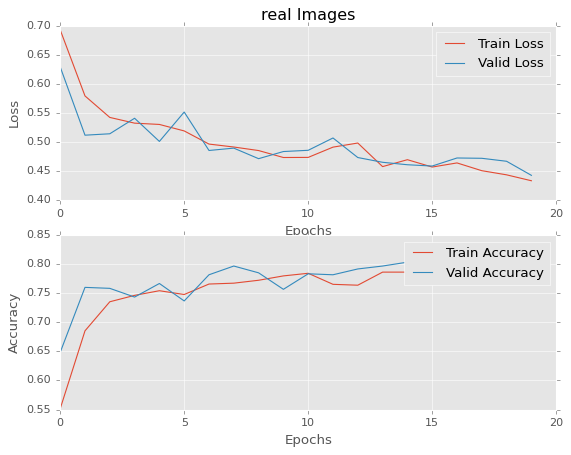

REAL 
Train: 0.8026973009109497 
Valid: 0.8133333325386047


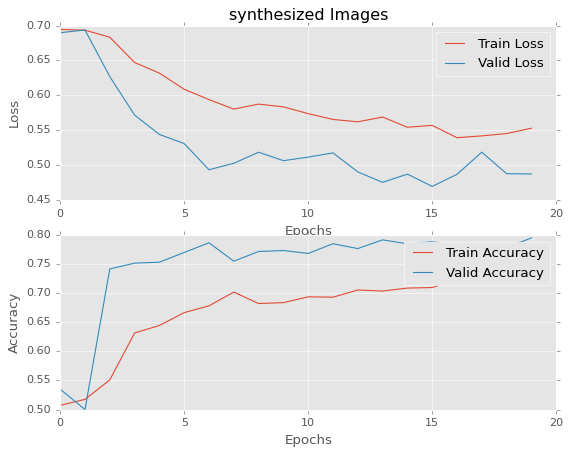

SYNTHESIZED 
Train: 0.7242003679275513 
Valid: 0.7950000166893005


In [58]:
#@markdown ## Evaluate Model

for h in hist.keys():
    his = hist[h]

    plt.style.use("ggplot")

    plt.subplot(2, 1, 1)
    plt.title(f"{h} Images")
    plt.plot(his.history['loss'], label="Train Loss")
    plt.plot(his.history['val_loss'], label="Valid Loss")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")

    plt.subplot(2, 1, 2)
    plt.plot(his.history['accuracy'], label="Train Accuracy")
    plt.plot(his.history['val_accuracy'], label="Valid Accuracy")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")

    plt.show()

    print(h.upper(), "\nTrain:", his.history['accuracy'][-1], "\nValid:", his.history['val_accuracy'][-1])

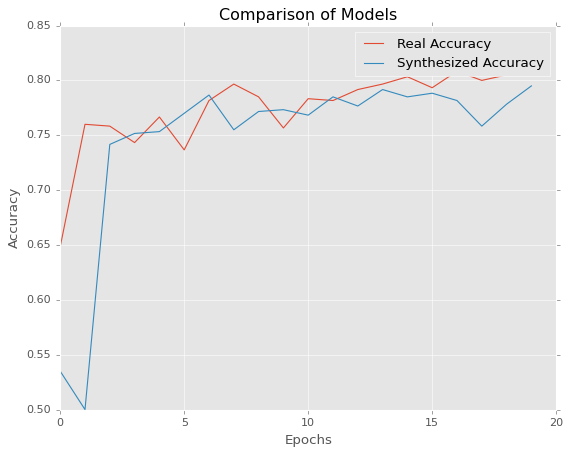

In [59]:
#@markdown ## Compare Models

plt.style.use("ggplot")
plt.subplot(1, 1, 1)
plt.title(f"Comparison of Models")

for h in hist.keys():
    his = hist[h]
    plt.plot(his.history['val_accuracy'], label=f"{h.capitalize()} Accuracy")

plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()